##  Анализ и прогнозирование арендной платы (House Rent Prediction)

Импорт библиотек.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

Загружаем датасет.

In [ ]:
data = pd.read_csv('House_Rent_Dataset.csv')
data.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


Посмотрим размер датасета.

In [ ]:
data.shape

(4746, 12)

Переименуем колонки для удобства.

In [ ]:
data.columns = data.columns.str.replace(' ', '_').str.lower()

Общая информация о колонках.

In [ ]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   posted_on          4746 non-null   object
 1   bhk                4746 non-null   int64 
 2   rent               4746 non-null   int64 
 3   size               4746 non-null   int64 
 4   floor              4746 non-null   object
 5   area_type          4746 non-null   object
 6   area_locality      4746 non-null   object
 7   city               4746 non-null   object
 8   furnishing_status  4746 non-null   object
 9   tenant_preferred   4746 non-null   object
 10  bathroom           4746 non-null   int64 
 11  point_of_contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


,bhk,rent,size,bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


Оценим количество пропусков.

In [ ]:
data.isnull().sum()

,0
posted_on,0
bhk,0
rent,0
size,0
floor,0
area_type,0
area_locality,0
city,0
furnishing_status,0
tenant_preferred,0


Оценим количество дубликатов.

In [ ]:
data.duplicated().sum()

0

Выделим числовые колонки.

In [ ]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns

Построим боксплоты.

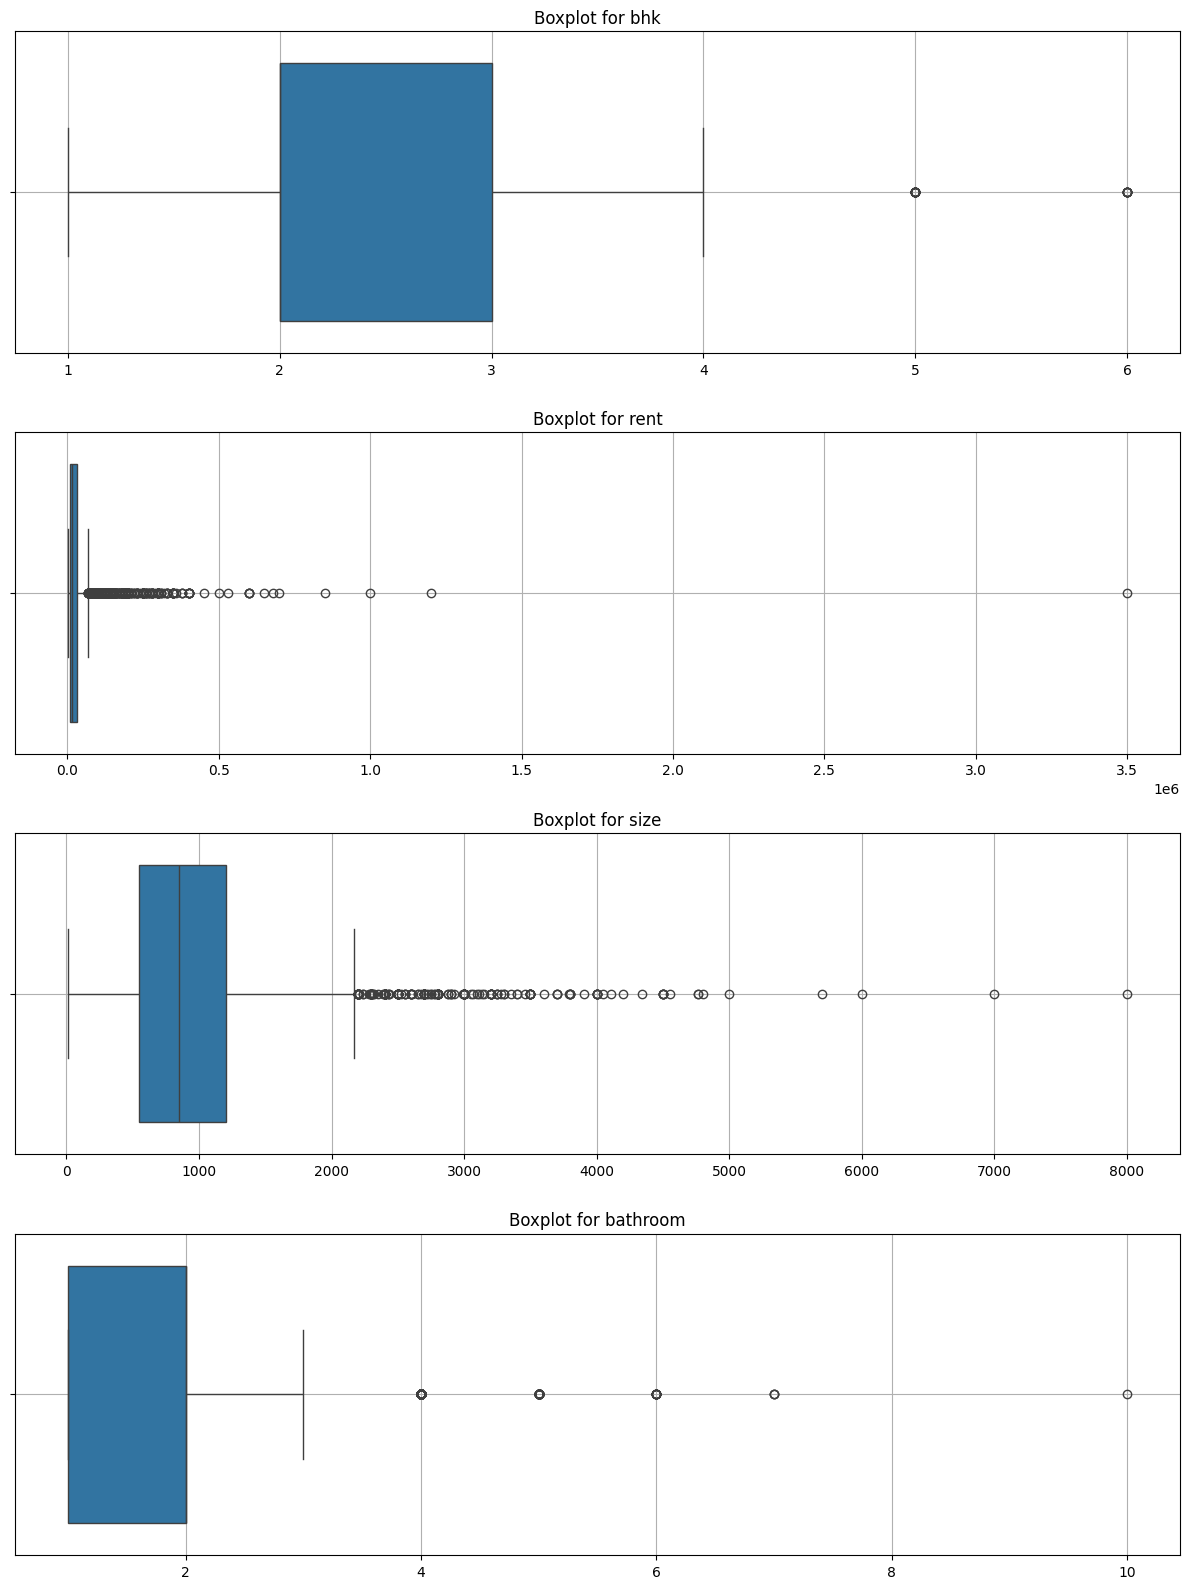

In [ ]:
plt.figure(figsize=(12, len(numerical_features) * 4))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features), 1, i)
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot for {col}")
    plt.xlabel("")
    plt.grid(True)

plt.tight_layout()
plt.show()

Построим гистограммы.

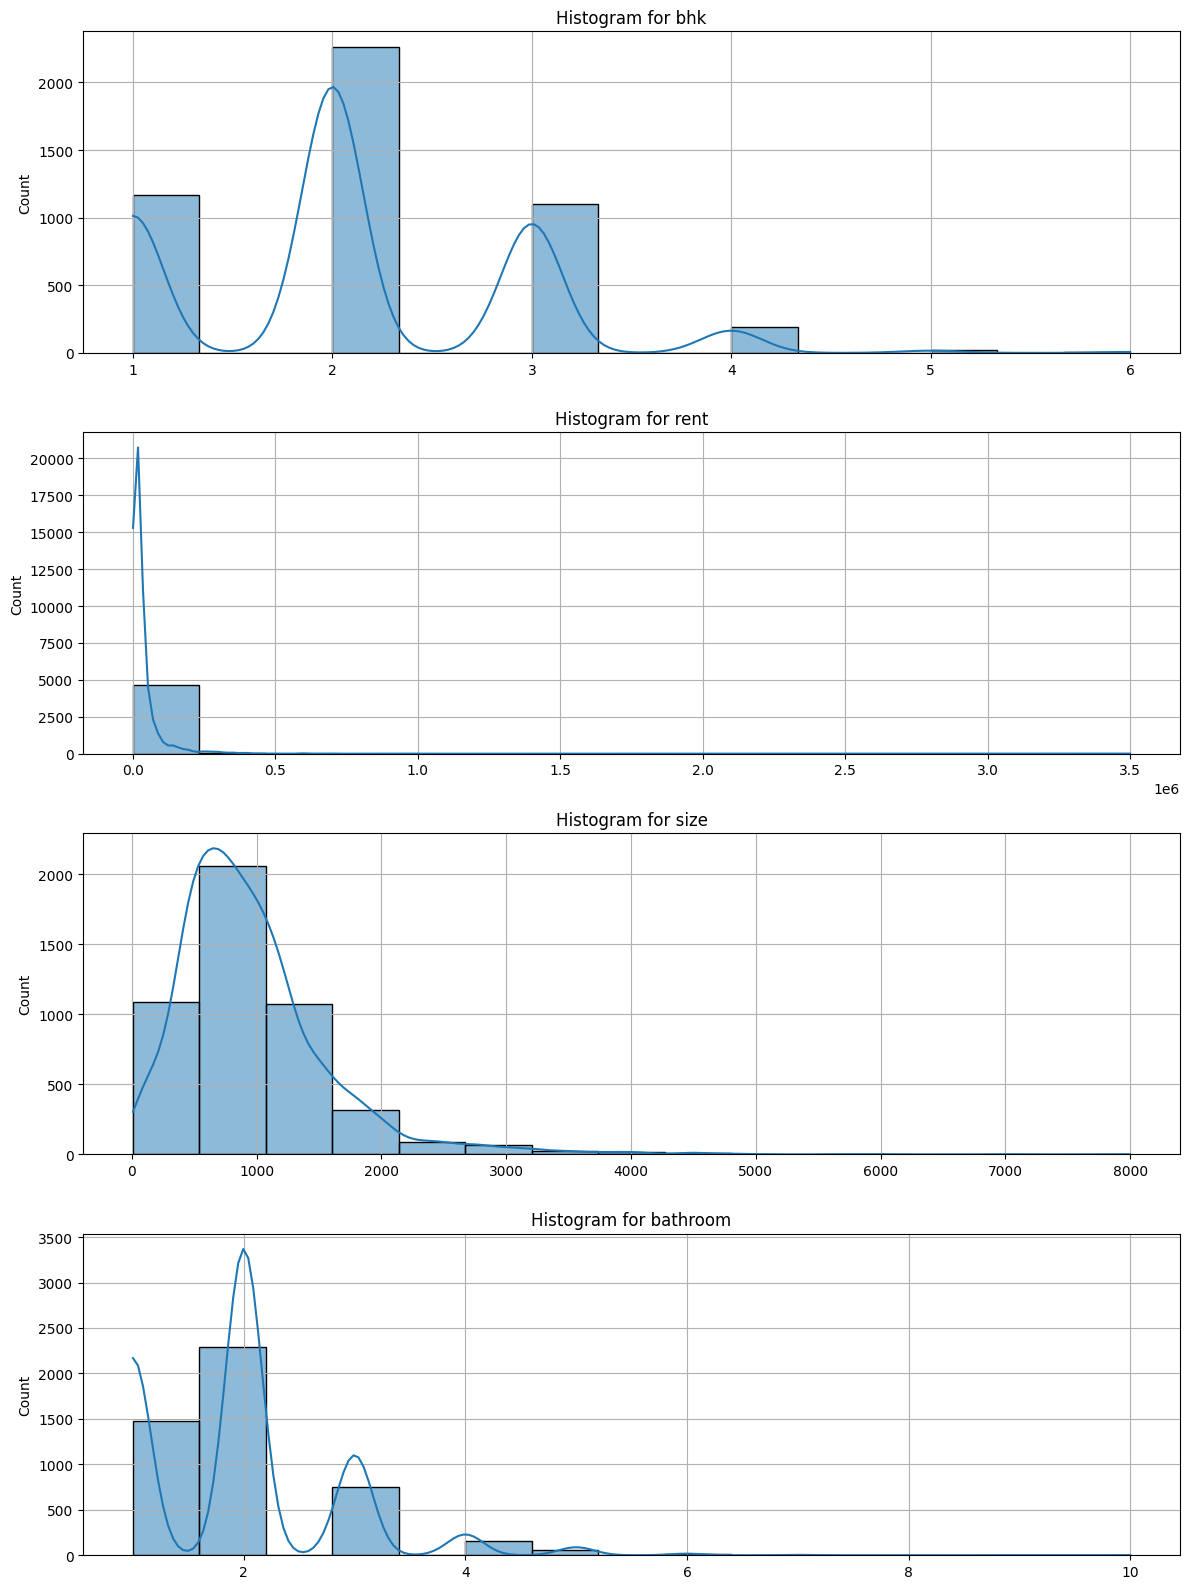

In [ ]:
plt.figure(figsize=(12, len(numerical_features) * 4))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features), 1, i)
    sns.histplot(data[col], bins=15, kde=True)
    plt.title(f"Histogram for {col}")
    plt.xlabel("")
    plt.grid(True)

plt.tight_layout()
plt.show()

Выводы:
все распределения смещены, имеют "длинный хвост" справа, что означает наличие экстремально высоких значений.
1. ВНК (количество комнат) - основная масса в диапазоне от 1 до 3, есть редкие значения 4, 5 и 6, что может быть либо признаком элитного жилья, либо выбросом.
2. Rent (аренда) - очень широкий разброс значений, много выбросов со стоимостью до 3.5. Скорее всего, есть редкие, но очень дорогие квартиры.
3. Size (размер) - большая часть квартир до 2000. Много выбросов до 8000.
4. Bathroom (количество ванных) - в основном квартиры имеют 1-3 санузла. Есть редкие варианты 4 - 10 санузлов. Возможно, 10 санузлов - ошибка в данных.


Оценим корреляцию между признаками.

In [ ]:
correlation_matrix = data[numerical_features].corr()
correlation_matrix

,bhk,rent,size,bathroom
bhk,1.000000,0.369718,0.716145,0.794885
rent,0.369718,1.000000,0.413551,0.441215
size,0.716145,0.413551,1.000000,0.740703
bathroom,0.794885,0.441215,0.740703,1.000000


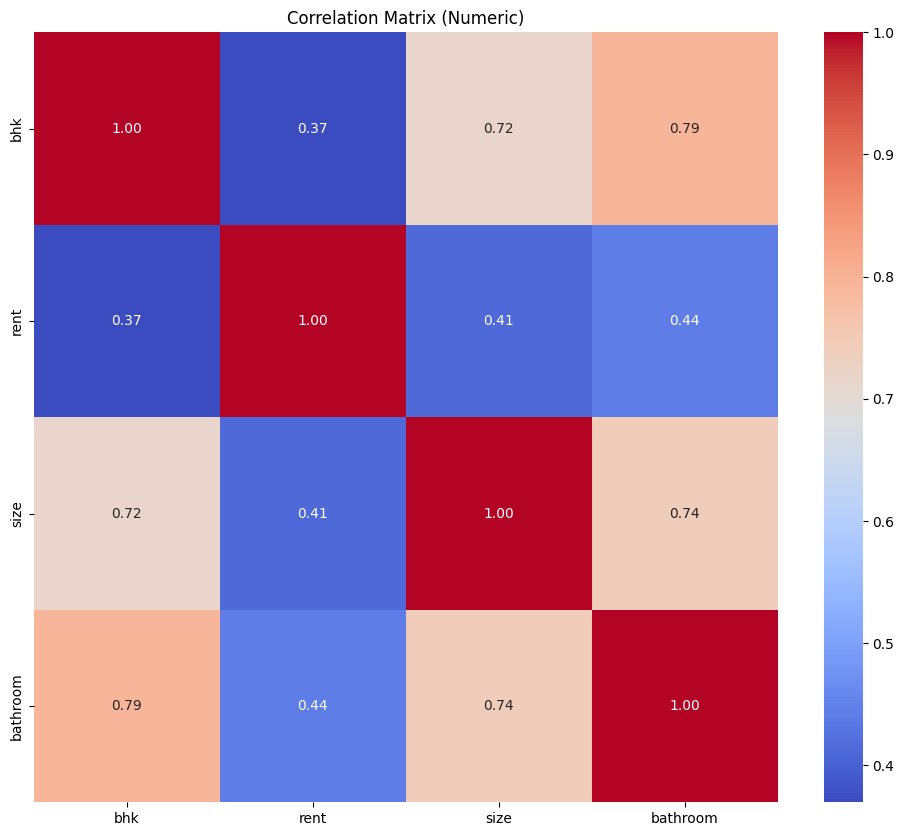

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numeric)")
plt.show()

Наблюдаем сильную корелляцию между количеством комнат и площадью, и количеством комнат и санузлов, что довольно естественно.

Также есть корреляция между площадью и стоимостью аренды, что логично т.к. недвижимость большей площади обычно дороже.
И корреляция между арендой и количеством ванных, что следует из предыдущих пунктов.

Для уменьшения влияния выбросов можно отфильтровать данные за пределами [Q1 - 1.5 × IQR, Q3 + 1.5 × IQR], но это может удалить редкие, но реальные наблюдения. Можно удалить явные выбросы и логарифмировать значения Rent и Size.

Оценим количество выбросов в Bathroom и BHK.

In [ ]:
data['bathroom'].value_counts()

,count
bathroom,
2,2291
1,1474
3,749
4,156
5,60
6,12
7,3
10,1


Оставим записи с значениями Bathroom < 7.

In [ ]:
data = data[data['bathroom'] < 7]

In [ ]:
data['bhk'].value_counts()

,count
bhk,
2,2265
1,1166
3,1098
4,188
5,19
6,6


Значения 5 и 6 - выбросы с довольно небольшим количеством записей. Вместо удаления таких записей заменим их медианным значением, чтобы уменьшить влияние на наши модели.

In [ ]:
bhk_median = data['bhk'].median()
data['bhk'] = np.where(data['bhk'] > 4, bhk_median, data['bhk'])

<ipython-input-16-e16fc0f10de9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bhk'] = np.where(data['bhk'] > 4, bhk_median, data['bhk'])


Прологарифмируем значения Rent и Size.

In [ ]:
data['rent'] = np.log(data['rent'])
data['size'] = np.log(data['size'])

Посмотрим на гистограммы после преобразования.

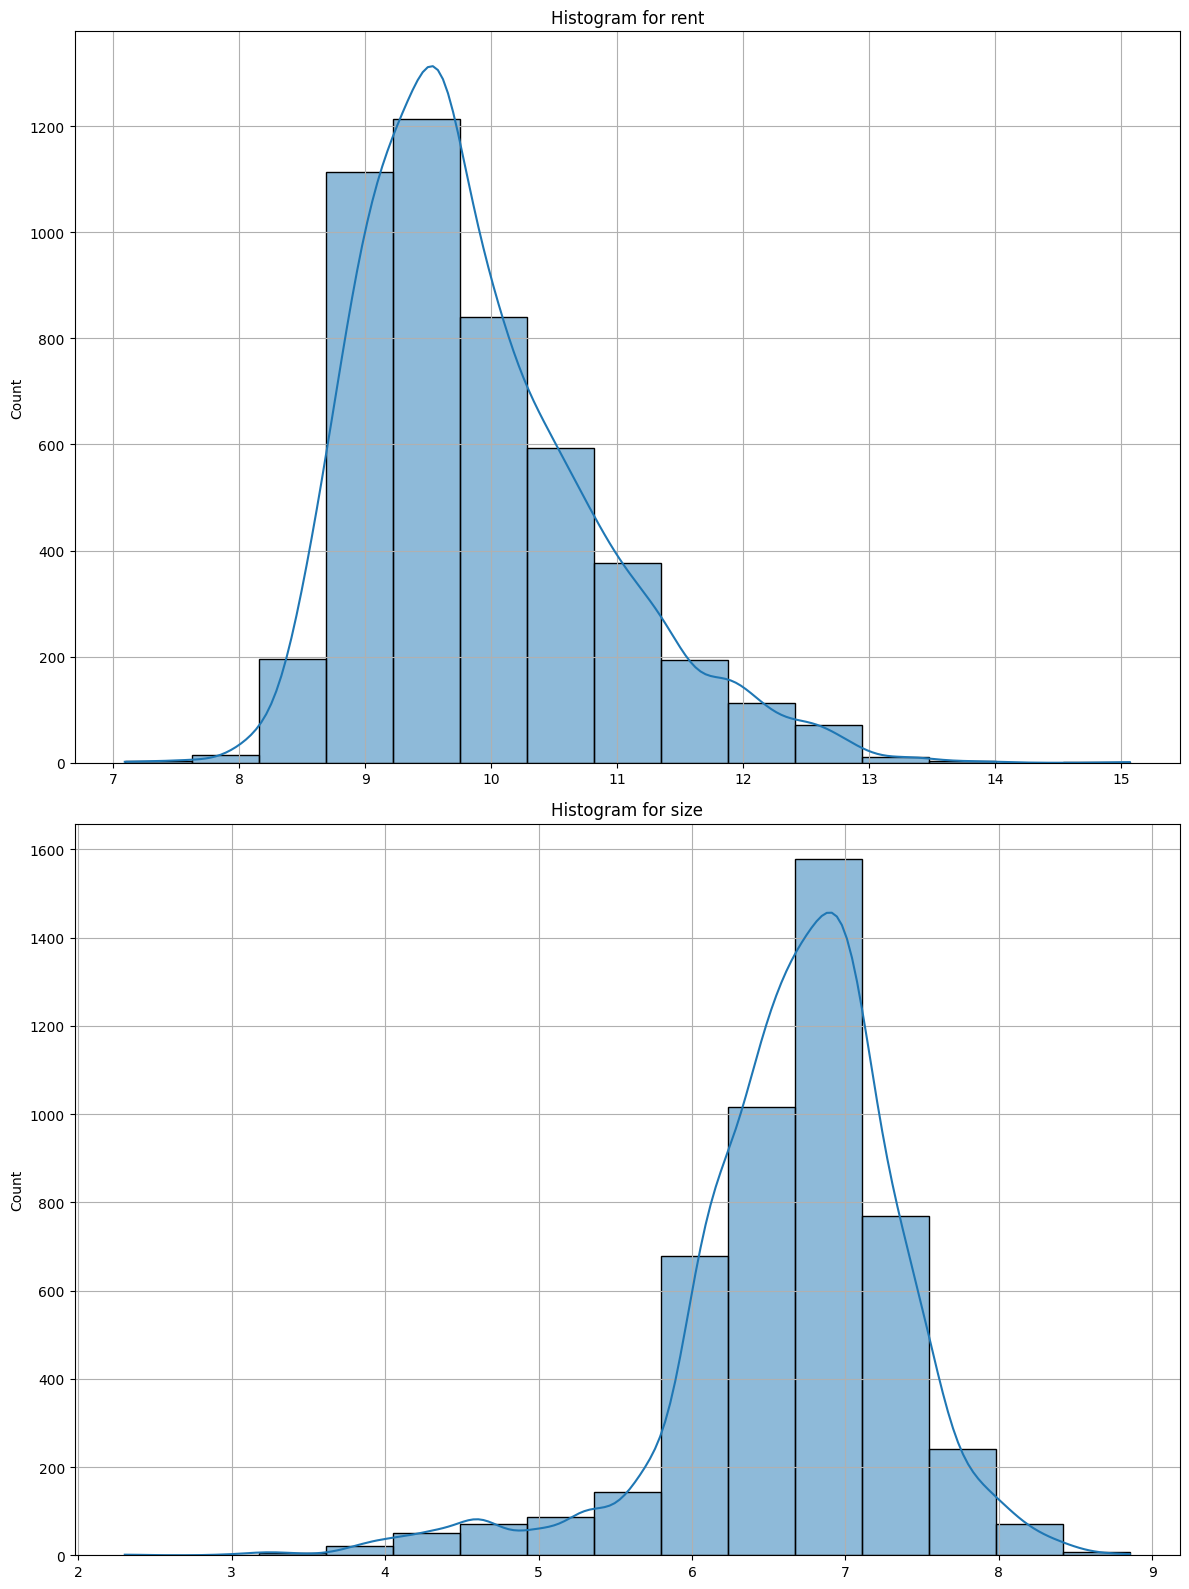

In [ ]:
plt.figure(figsize=(12, len(numerical_features) * 4))
for i, col in enumerate(['rent', 'size'], 1):
    plt.subplot(len(['rent', 'size']), 1, i)
    sns.histplot(data[col], bins=15, kde=True)
    plt.title(f"Histogram for {col}")
    plt.xlabel("")
    plt.grid(True)

plt.tight_layout()
plt.show()

Видим, что теперь распределения Rent и Size более приближены к нормальному.

Поработаем с нечисловыми признаками.

Преобразуем "posted_on" в формат datetime и извлечем year, month, day_of_week.

In [ ]:
data['posted_on'] = pd.to_datetime(data['posted_on'])

data['year'] = data['posted_on'].dt.year
data['month'] = data['posted_on'].dt.month
data['day_of_week'] = data['posted_on'].dt.dayofweek

data = data.drop(columns=['posted_on'])

data.head()

,bhk,rent,size,floor,area_type,area_locality,city,furnishing_status,tenant_preferred,bathroom,point_of_contact,year,month,day_of_week
0,2.0,9.210340,7.003065,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,2022,5,2
1,2.0,9.903488,6.684612,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,2022,5,4
2,2.0,9.740969,6.907755,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,2022,5,0
3,2.0,9.210340,6.684612,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2022,7,0
4,2.0,8.922658,6.745236,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2022,5,0


Обработка столбца "floor". Выделим текущий этаж и сколько всего этажей в здании.

In [ ]:
data[['floor_current', 'floor_total']] = data['floor'].str.split(' out of ', expand=True)
data['floor_current'].unique()

array(['Ground', '1', '2', '4', '3', '5', '7', '8', 'Upper Basement',
       '11', 'Lower Basement', '6', '14', '43', '13', '18', '17', '9',
       '19', '60', '34', '12', '26', '25', '53', '16', '10', '39', '32',
       '47', '28', '20', '15', '65', '40', '37', '22', '21', '30', '35',
       '33', '44', '41', '46', '27', '45', '48', '50', '24', '23', '29',
       '49', '36', '76'], dtype=object)

Значения 'Ground', 'Upper Basement' и 'Lower Basement' заменим на числовые.

In [ ]:
data['floor_current'] = data['floor_current'].replace({
    'Ground': 0,
    'Upper Basement': -1,
    'Lower Basement': -2
}).astype(int)
data['floor_current'].unique()

array([ 0,  1,  2,  4,  3,  5,  7,  8, -1, 11, -2,  6, 14, 43, 13, 18, 17,
        9, 19, 60, 34, 12, 26, 25, 53, 16, 10, 39, 32, 47, 28, 20, 15, 65,
       40, 37, 22, 21, 30, 35, 33, 44, 41, 46, 27, 45, 48, 50, 24, 23, 29,
       49, 36, 76])

Оценим значения Floor_Total.

In [ ]:
data['floor_total'].unique()

array(['2', '3', '1', '4', '5', '14', '8', '6', '19', '10', '7', '13',
       '78', '18', '12', '24', '31', '21', '23', '20', '9', '22', '58',
       '16', '66', '48', '40', '44', '42', '41', '60', '32', '30', '29',
       '89', '15', '11', '28', '17', '45', '35', '75', '38', '51', '43',
       '25', '27', '26', '76', '36', '37', '55', '68', '77', '50', '59',
       '62', '39', '52', '54', '33', '46', '85', '71', '81', '34', None],
      dtype=object)

In [ ]:
data.loc[data['floor'] == '3']

,bhk,rent,size,floor,area_type,area_locality,city,furnishing_status,tenant_preferred,bathroom,point_of_contact,year,month,day_of_week,floor_current,floor_total
2553,2.0,9.903488,5.991465,3,Super Area,"Kasturba Niketan, Lajpat Nagar 2",Delhi,Unfurnished,Bachelors/Family,1,Contact Owner,2022,6,5,3,None


Всего одна запись с пропущенным значением, удалим ее.

In [ ]:
data = data[data['floor_total'].notna()].reset_index(drop=True)
data['floor_total'] = data['floor_total'].astype(int)
data = data.drop(columns=['floor'])
data.head()

,bhk,rent,size,area_type,area_locality,city,furnishing_status,tenant_preferred,bathroom,point_of_contact,year,month,day_of_week,floor_current,floor_total
0,2.0,9.210340,7.003065,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,2022,5,2,0,2
1,2.0,9.903488,6.684612,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,2022,5,4,1,3
2,2.0,9.740969,6.907755,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,2022,5,0,1,3
3,2.0,9.210340,6.684612,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2022,7,0,1,2
4,2.0,8.922658,6.745236,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2022,5,0,1,2


Рассмотрим признаки 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact'.

In [ ]:
data['area_type'].value_counts()

,count
area_type,
Super Area,2441
Carpet Area,2295
Built Area,2


К этому параметру можно применить One-Hot Encoding, отправив последнюю категорию в "Other".

In [ ]:
data['area_locality'].value_counts()

,count
area_locality,
Bandra West,37
Gachibowli,29
Electronic City,24
Velachery,22
"Miyapur, NH 9",22
...,...
"Sumit Greendale, Chikhal Dongari",1
"Sai Aasha Daya, Mulund East",1
"117 Residency, Chembur East",1


Слишком много разных значений, можем либо выделить топ-10 значений и остальные поместить в Other, и после применить One-Hot Encoding, либо применить Frequency Encoding, то есть заменить значение на его относительную частоту. Применим второй способ.

In [ ]:
data['city'].value_counts()

,count
city,
Mumbai,972
Chennai,891
Bangalore,886
Hyderabad,863
Delhi,602
Kolkata,524


Уникальных значений не так много и они относительно равномерно распределены, значит, можем использовать One-Hot Encoding.

In [ ]:
data['furnishing_status'].value_counts()

,count
furnishing_status,
Semi-Furnished,2249
Unfurnished,1812
Furnished,677


То же, что и City.

In [ ]:
data['tenant_preferred'].value_counts()

,count
tenant_preferred,
Bachelors/Family,3438
Bachelors,829
Family,471


То же, что и City.

In [ ]:
data['point_of_contact'].value_counts()

,count
point_of_contact,
Contact Owner,3209
Contact Agent,1528
Contact Builder,1


Та же ситуация, что и с 'Area Type'.

Итого:
</br>
* 'area_type', 'point_of_contact' - OHE c Other
* 'city', 'furnishing_status', 'tenant_preferred' - OHE c drop_first=True
* 'area_locality' - FE
</br>


Применим преобразования:

In [ ]:
category_counts = data['area_type'].value_counts(normalize=True)
threshold = 0.05
rare_categories = category_counts[category_counts < threshold].index
data['area_type'] = data['area_type'].replace(rare_categories, 'other')
data['area_type'].value_counts()

,count
area_type,
Super Area,2441
Carpet Area,2295
other,2


In [ ]:
category_counts = data['point_of_contact'].value_counts(normalize=True)
threshold = 0.05
rare_categories = category_counts[category_counts < threshold].index
data['point_of_contact'] = data['point_of_contact'].replace(rare_categories, 'other')
data['point_of_contact'].value_counts()

,count
point_of_contact,
Contact Owner,3209
Contact Agent,1528
other,1


In [ ]:
data_encoded = pd.get_dummies(data, columns=['area_type', 'point_of_contact'], dtype=int)

In [ ]:
data_encoded = pd.get_dummies(data_encoded, columns=['city', 'furnishing_status', 'tenant_preferred'], dtype=int, drop_first=True)

In [ ]:
category_frequencies = data_encoded['area_locality'].value_counts(normalize=True)
data_encoded['area_locality'] = data_encoded['area_locality'].map(category_frequencies)

In [ ]:
data_encoded.head()

,bhk,rent,size,area_locality,bathroom,year,month,day_of_week,floor_current,floor_total,area_type_Carpet Area,area_type_Super Area,area_type_other,point_of_contact_Contact Agent,point_of_contact_Contact Owner,point_of_contact_other,city_Chennai,city_Delhi,city_Hyderabad,city_Kolkata,city_Mumbai,furnishing_status_Semi-Furnished,furnishing_status_Unfurnished,tenant_preferred_Bachelors/Family,tenant_preferred_Family
0,2.0,9.210340,7.003065,0.000422,2,2022,5,2,0,2,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0
1,2.0,9.903488,6.684612,0.000422,1,2022,5,4,1,3,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0
2,2.0,9.740969,6.907755,0.003377,1,2022,5,0,1,3,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0
3,2.0,9.210340,6.684612,0.000422,1,2022,7,0,1,2,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0
4,2.0,8.922658,6.745236,0.000211,1,2022,5,0,1,2,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0


Посмотрим на год.

In [ ]:
data_encoded['year'].unique()

array([2022], dtype=int32)

In [ ]:
data_encoded = data_encoded.drop(columns=['year'])

In [ ]:
numerical_features = numerical_features.append(pd.Index(['floor_current', 'floor_total']))

In [ ]:
correlation_matrix = data_encoded[numerical_features].corr()
correlation_matrix

,bhk,rent,size,bathroom,floor_current,floor_total
bhk,1.000000,0.579900,0.613049,0.772849,0.230324,0.254673
rent,0.579900,1.000000,0.484725,0.697136,0.499455,0.556626
size,0.613049,0.484725,1.000000,0.609869,0.162436,0.183705
bathroom,0.772849,0.697136,0.609869,1.000000,0.339493,0.371396
floor_current,0.230324,0.499455,0.162436,0.339493,1.000000,0.861898
floor_total,0.254673,0.556626,0.183705,0.371396,0.861898,1.000000


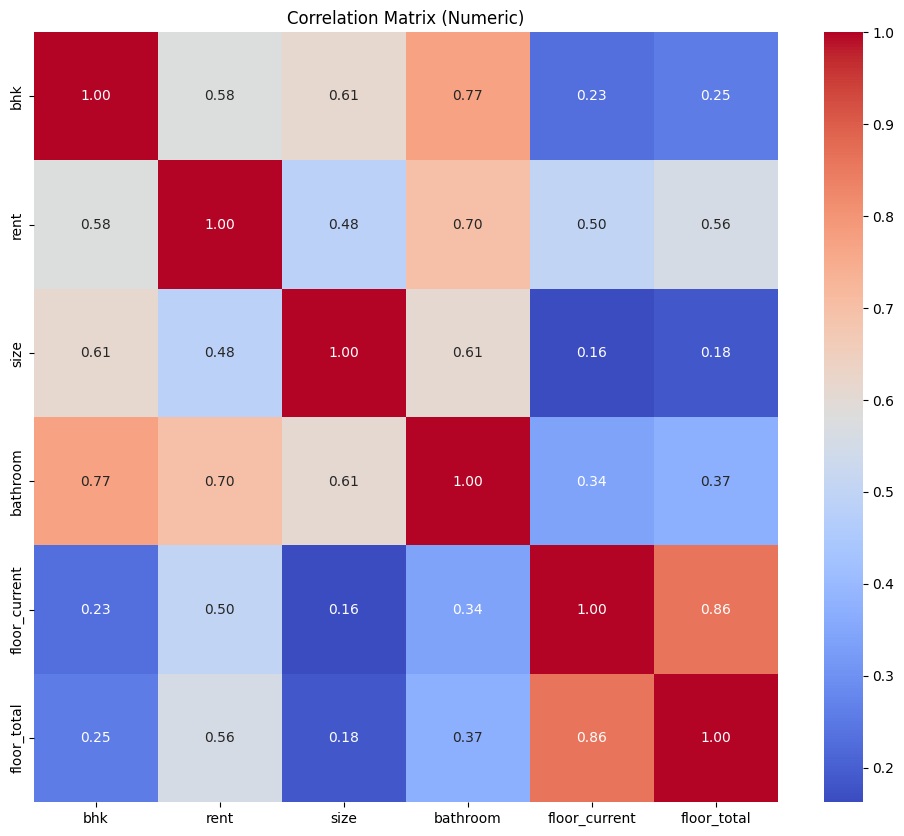

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numeric)")
plt.show()

Самая высокая корреляция у floor_current и floor_total.
Наблюдается корреляция у rent и bathroom, rent и size, rent и bhk.

Создадим новую переменную и уберем коррелирующие.

In [ ]:
data_encoded['bedroom_density'] = data_encoded['bhk'] / data['size']
data_encoded = data_encoded.drop(columns=['bhk', 'size', 'bathroom', 'floor_total'])
data_encoded.head()

,rent,area_locality,month,day_of_week,floor_current,area_type_Carpet Area,area_type_Super Area,area_type_other,point_of_contact_Contact Agent,point_of_contact_Contact Owner,point_of_contact_other,city_Chennai,city_Delhi,city_Hyderabad,city_Kolkata,city_Mumbai,furnishing_status_Semi-Furnished,furnishing_status_Unfurnished,tenant_preferred_Bachelors/Family,tenant_preferred_Family,bedroom_density
0,9.210340,0.000422,5,2,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0.285589
1,9.903488,0.000422,5,4,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0.299195
2,9.740969,0.003377,5,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0.289530
3,9.210340,0.000422,7,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0.299195
4,8.922658,0.000211,5,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0.296506


In [ ]:
numerical_features = ['bedroom_density', 'rent', 'floor_current']

Нормализуем числовые признаки

In [ ]:
scaler = StandardScaler()
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])

Разделяем на признаки и целевую переменную.

In [ ]:
X = data_encoded.drop(columns=['rent'])
y = data_encoded['rent']

Разделяем на тренировочную и тестовую выборки. Обращаем логарифмирование целевой переменной.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_test = np.exp(y_test)

Перебираем модели и сравниваем метрики:

In [ ]:
# Строим модель линейной регрессии
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = np.exp(lr_model.predict(X_test))

# Оценка качества модели
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Linear Regression MAE: {mae_lr}")
print(f"Linear Regression RMSE: {rmse_lr}")


# Строим модель линейной регрессии c регуляризацией
rg_model = Ridge()
rg_model.fit(X_train, y_train)
y_pred_rg = np.exp(rg_model.predict(X_test))

# Оценка качества модели
mae_rg = mean_absolute_error(y_test, y_pred_rg)
rmse_rg = np.sqrt(mean_squared_error(y_test, y_pred_rg))
print(f"Ridge MAE: {mae_rg}")
print(f"Ridge RMSE: {rmse_rg}")


# Строим модель случайного леса
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = np.exp(rf_model.predict(X_test))

# Оценка качества модели
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest MAE: {mae_rf}")
print(f"Random Forest RMSE: {rmse_rf}")


# Строим модель XGB
xgb_model = XGBRegressor(n_estimators=100, max_depth=2, learning_rate=1, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
y_pred_xgb = np.exp(xgb_model.predict(X_test))

# Оценка качества модели
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBRegressor MAE: {mae_xgb}")
print(f"XGBRegressor RMSE: {rmse_xgb}")

Linear Regression MAE: 1.0091390945542889
Linear Regression RMSE: 7.293303474188102
Ridge MAE: 1.0192220073052174
Ridge RMSE: 7.300872566832353
Random Forest MAE: 0.8224133374107224
Random Forest RMSE: 7.148536889903172
XGBRegressor MAE: 0.8671326380637349
XGBRegressor RMSE: 7.146804760346986


Random Forest показывает лучшие результаты по MAE и RMSE, на втором месте XGBRegressor.
Линейные модели работают хуже - вероятно, данные имеют нелинейные зависимости.
Попробуем подобрать гиперпараметры для XGBRegressor и Random Forest.

Подбор гиперпараметров для Random Forest
* n_estimators (число деревьев)
* max_depth (глубина дерева)
* min_samples_split (минимум объектов для разделения)
* min_samples_leaf (минимум объектов в листе)


In [ ]:
rf_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 5]
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                       param_grid=rf_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print(f"Лучшие параметры Random Forest: {rf_grid.best_params_}")
print(f"RMSE: {-rf_grid.best_score_}")

Лучшие параметры Random Forest: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
RMSE: 0.4650547202371834


Подбор гиперпараметров для XGBoost
* n_estimators (число деревьев)
* max_depth (глубина дерева)
* learning_rate (скорость обучения)
* subsample (доля выборки для обучения)
* colsample_bytree (доля признаков при построении каждого дерева)

In [ ]:
xgb_params = {
    'n_estimators': [30, 50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_grid = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42),
                        param_grid=xgb_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print(f"Лучшие параметры XGBoost: {xgb_grid.best_params_}")
print(f"RMSE: {-xgb_grid.best_score_}")

Лучшие параметры XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
RMSE: 0.4519812677274195


Как финальное решение выбираем XGBoost с параметрами, подобранными с помощью GridSearchCV.

In [ ]:
best_model = xgb_grid.best_estimator_
best_model.fit(X_train, y_train)
y_pred = np.exp(best_model.predict(X_test))

Оценка качества модели:

In [ ]:
mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"XGBRegressor MAE: {mae_xgb}")
print(f"XGBRegressor RMSE: {rmse_xgb}")

XGBRegressor MAE: 0.8027072632894423
XGBRegressor RMSE: 7.031341906559533



Проверим Random Forest.

In [ ]:
best_model_rf = rf_grid.best_estimator_
best_model_rf.fit(X_train, y_train)
y_pred_rf = np.exp(best_model_rf.predict(X_test))

In [ ]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest MAE: {mae_rf}")
print(f"Random Forest RMSE: {rmse_rf}")

Random Forest MAE: 0.8222912372213643
Random Forest RMSE: 7.129896248254021


Вывод: лучший результат показывает XGBRegressor после оптимизации параметров.